# [Jansen-Rit whole brain Numba imentation](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/jansen_rit_sde_numba_cde.ipynb)
 
<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/jansen_rit_sde_numba_cde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [ ]:
# Install VBI package in Google Colab (lightweight, CPU-only version)
print("Setting up VBI for Google Colab...")

# Skip C++ compilation for faster installation in Colab
%env SKIP_CPP=1

# Install the package
!pip install vbi

print("VBI package installed successfully! Ready to proceed.")

1) Imports & Global Configuration

In [76]:
import os
from copy import deepcopy
from multiprocessing import Pool

In [ ]:
import numpy as np
import autograd.numpy as anp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import signal
from sklearn.preprocessing import StandardScaler

In [78]:
import vbi
from vbi.models.numba.jansen_rit import JR_sde
from vbi import report_cfg, update_cfg
from vbi import extract_features_df
from vbi import get_features_by_domain, get_features_by_given_names
from vbi.utils import BoxUniform, posterior_shrinkage_numpy, posterior_zscore_numpy
from vbi.cde import MAFEstimator  # your (sbi-like) CDE estimator

In [ ]:

def plot_ts_pxx_jr(data, par, ax, **kwargs):
    tspan = data['t']
    y = data['x']
    ax[0].plot(tspan, y.T, label='y1 - y2', **kwargs)
    freq, pxx = signal.welch(y, 1000/par['dt'], nperseg=y.shape[1]//2)
    ax[1].plot(freq, pxx.T, **kwargs)
    ax[1].set_xlim(0, 50)
    ax[1].set_xlabel("frequency [Hz]")
    ax[0].set_xlabel("time [ms]")
    ax[0].set_ylabel("y1-y2")
    ax[0].margins(x=0)

    plt.tight_layout()



Reproducibility & output

In [81]:
RNG_SEED: int = 2
np.random.seed(RNG_SEED)

In [82]:
OUT_DIR = "output/jansen_rit_sde_numba_cde_/"
os.makedirs(OUT_DIR, exist_ok=True)

Matplotlib aesthetics

In [83]:
LABEL_SIZE = 12
plt.rcParams["axes.labelsize"] = LABEL_SIZE
plt.rcParams["xtick.labelsize"] = LABEL_SIZE
plt.rcParams["ytick.labelsize"] = LABEL_SIZE

Data/control flags

In [ ]:
LOAD_DATA: bool = True   # <— Set True to load cached dataset if available
SAVE_DATA: bool = True   # Save dataset after (re)simulation
CACHE_FILE = os.path.join(OUT_DIR, "jr_cde_dataset.npz")

2) Structural Connectivity & Preview

Load sample connectome (nn: number of nodes) and preview

In [87]:
sample = vbi.LoadSample(nn=84)
CONNECTIVITY = sample.get_weights()
N_NODES = CONNECTIVITY.shape[0]
print(f"number of nodes: {N_NODES}")

number of nodes: 84


Quick visual check of the adjacency (can be toggled off if desired)

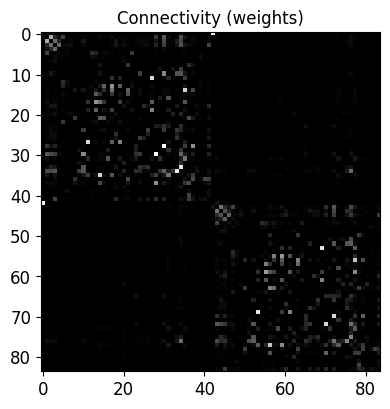

In [88]:
if True:
    fig, ax = plt.subplots(1, 1, figsize=(4, 4.5))
    im = ax.imshow(CONNECTIVITY, cmap="gray", vmin=0, vmax=1)
    ax.set_title("Connectivity (weights)")
    plt.tight_layout()

3) Simulator parameters & one reference run

JR SDE base parameters (units: ms where applicable)

In [89]:
SIM_CFG = {
    "G": 1.0,            # global coupling (will be overridden per-control)
    "mu": 0.24,          # external input
    "noise_amp": 0.1,
    "dt": 0.05,          # ms
    "C0": 135.0 * 1.0,
    "C1": 135.0 * 0.8,
    "C2": 135.0 * 0.25,
    "C3": 135.0 * 0.25,
    "weights": CONNECTIVITY,
    "t_cut": 500.0,      # ms — discard transient
    "t_end": 2501.0,     # ms — total duration
    "seed": RNG_SEED,
    "decimate": 1,
}

Reference ground truth parameters for evaluation/plots

In [90]:
TRUE_THETA = np.array([1.5, 135.0], dtype=np.float32)  # [G, C1]
TRUE_CONTROL = {"G": float(TRUE_THETA[0]), "C1": float(TRUE_THETA[1])}

One quick simulation preview

In [91]:
jr_ref = JR_sde(SIM_CFG)
ref_sol = jr_ref.run(TRUE_CONTROL)
print(ref_sol["t"].shape, ref_sol["x"].shape)

(40020,) (40020, 84)


Time series + spectrum preview

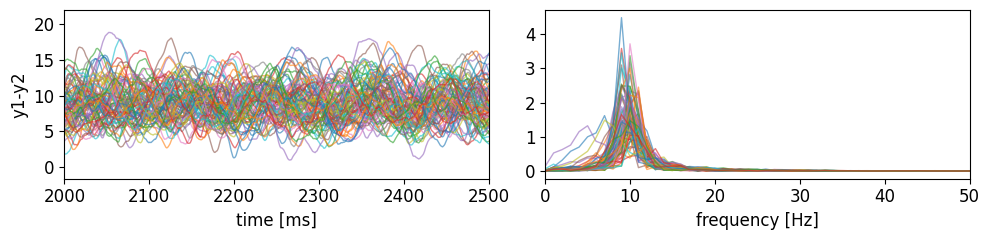

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(10, 2.5))
plot_ts_pxx_jr({"t": ref_sol["t"], "x": ref_sol["x"].T}, SIM_CFG, [ax[0], ax[1]], alpha=0.6, lw=1)
ax[0].set_xlim(2000, 2500)
plt.tight_layout()

4) Feature configuration (spectral domain)

Configure spectral features and fix sampling frequency

In [93]:
feat_cfg = get_features_by_domain(domain="spectral")
feat_cfg = get_features_by_given_names(
    feat_cfg, names=["spectrum_stats", "spectrum_auc", "spectrum_moments"]
)
fs_hz = 1000.0 / SIM_CFG["dt"]  # Hz
for key in ("spectrum_stats", "spectrum_auc", "spectrum_moments"):
    update_cfg(feat_cfg, key, {"fs": fs_hz, "method": "welch", "average": True})
report_cfg(feat_cfg)

Selected features:
------------------
■ Domain: spectral
 ▢ Function:  spectrum_stats
   ▫ description:  Computes the spectrum of the signal.
   ▫ function   :  vbi.feature_extraction.features.spectrum_stats
   ▫ parameters :  {'fs': 20000.0, 'nperseg': None, 'indices': None, 'verbose': False, 'average': True, 'method': 'welch', 'features': ['spectral_distance', 'fundamental_frequency', 'max_frequency', 'max_psd', 'median_frequency', 'spectral_centroid', 'spectral_kurtosis', 'spectral_variation']}
   ▫ tag        :  all
   ▫ use        :  yes
 ▢ Function:  spectrum_moments
   ▫ description:  Computes the spectrum of the signal.
   ▫ function   :  vbi.feature_extraction.features.spectrum_moments
   ▫ parameters :  {'fs': 20000.0, 'nperseg': None, 'method': 'welch', 'moments': [2, 3, 4, 5, 6], 'normalize': False, 'verbose': False, 'indices': None, 'average': True}
   ▫ tag        :  all
   ▫ use        :  yes
 ▢ Function:  spectrum_auc
   ▫ description:  Computes the area under the curve

5) Simulation → feature pipeline (single & batch)

In [94]:
def simulate_and_extract(sim_cfg: dict, control_pair, cfg, *, return_labels=False, verbose=False):
    """Run JR SDE for control (G, C1) and extract features.
    Parameters
    ----------
    sim_cfg : dict
        Base simulator configuration (copied internally).
    control_pair : tuple(float, float)
        (G, C1) values.
    cfg : Any
        Feature-extraction configuration from vbi.
    return_labels : bool
        Also return the feature labels.
    Returns
    -------
    np.ndarray or (np.ndarray, list[str])
        Feature vector (and labels if requested).
    """
    g_val, c1_val = control_pair
    local_cfg = deepcopy(sim_cfg)
    controls = {"G": float(g_val), "C1": float(c1_val)}
    solver = JR_sde(local_cfg)
    sol = solver.run(controls)

    # Extract features per node, then aggregate as configured
    stats = extract_features_df(
        ts=[sol["x"].T], cfg=cfg, fs=fs_hz, n_workers=1, verbose=verbose
    )
    vec = stats.values[0]
    if return_labels:
        return vec, list(stats.columns)
    return vec

In [95]:
def run_batch(sim_cfg: dict, control_list, cfg, n_workers: int = 1):
    """Parallel batch of simulate_and_extract with a tqdm progress bar."""
    n_total = len(control_list)
    def _update(_):
        pbar.update()
    with Pool(processes=n_workers) as pool:
        with tqdm(total=n_total, desc="Simulations") as pbar:
            async_results = [
                pool.apply_async(
                    simulate_and_extract, args=(sim_cfg, control_list[i], cfg), callback=_update
                )
                for i in range(n_total)
            ]
            features_list = [res.get() for res in async_results]
    return features_list

Probe labels once

In [96]:
feat_vec_probe, FEATURE_LABELS = simulate_and_extract(SIM_CFG, TRUE_THETA, feat_cfg, return_labels=True)
print(f"n_features (raw): {len(feat_vec_probe)}")

n_features (raw): 18


6) Prior and sampling of parameters (θ)

Define box prior for [G, C1]

In [97]:
G_MIN, G_MAX = 0.0, 5.0
C1_MIN, C1_MAX = 130.0, 300.0
PRIOR_BOUNDS_MIN = [G_MIN, C1_MIN]
PRIOR_BOUNDS_MAX = [G_MAX, C1_MAX]
PRIOR = BoxUniform(low=PRIOR_BOUNDS_MIN, high=PRIOR_BOUNDS_MAX)

Simulation campaign settings

In [98]:
N_SIMULATIONS: int = 200
N_WORKERS: int = 10

7) Dataset build (with LOAD_DATA control)

In [99]:
if LOAD_DATA and os.path.exists(CACHE_FILE):
    # Reuse previously generated features and parameters
    cache = np.load(CACHE_FILE, allow_pickle=True)
    THETA = cache["theta"].astype(np.float32)
    FEATURES = cache["features"].astype(np.float32)
    SCALER_MEAN = cache["scaler_mean"].astype(np.float32)
    SCALER_SCALE = cache["scaler_scale"].astype(np.float32)
    NONZERO_MASK = cache["nonzero_mask"].astype(bool)
    FEATURE_LABELS = list(cache["labels"].tolist())
    print(f"Loaded cached dataset: {FEATURES.shape} features for {THETA.shape[0]} samples")
else:
    # Fresh simulations
    THETA = PRIOR.sample(N_SIMULATIONS, seed=RNG_SEED).astype(np.float32)
    raw_features = run_batch(SIM_CFG, THETA, feat_cfg, n_workers=N_WORKERS)
    FEATURES = np.asarray(raw_features, dtype=np.float32)

    # Standardize and optionally drop near-constant features
    scaler = StandardScaler()
    FEATURES = scaler.fit_transform(FEATURES).astype(np.float32)
    NONZERO_MASK = (np.var(FEATURES, axis=0) > 1e-6)
    FEATURES = FEATURES[:, NONZERO_MASK]
    SCALER_MEAN = scaler.mean_.astype(np.float32)
    # sklearn stores var_, convert to std as used in transform (avoid recomputing)
    SCALER_SCALE = scaler.scale_.astype(np.float32)
    if SAVE_DATA:
        np.savez(
            CACHE_FILE,
            theta=THETA,
            features=FEATURES,
            scaler_mean=SCALER_MEAN,
            scaler_scale=SCALER_SCALE,
            nonzero_mask=NONZERO_MASK,
            labels=np.array(FEATURE_LABELS, dtype=object),
        )
        print(f"Saved dataset cache → {CACHE_FILE}")

Simulations: 100%|██████████| 200/200 [01:09<00:00,  2.90it/s]

Saved dataset cache → output/jansen_rit_sde_numba_cde_/jr_cde_dataset.npz


8) Observation features (x₀) at TRUE_THETA

In [100]:
x0_vec = simulate_and_extract(SIM_CFG, TRUE_THETA, feat_cfg)
# Apply the same standardization/masking as training features
x0_std = ((x0_vec - SCALER_MEAN) / (SCALER_SCALE + 1e-12)).astype(np.float32)
x0_std = x0_std[NONZERO_MASK][None, :]  # shape (1, n_features_kept)

9) Train CDE (MAF) and sample posterior

NOTE: you can tune these (see your sbi-like MAF estimator)

In [101]:
maf_rng = anp.random.RandomState(RNG_SEED)
maf = MAFEstimator(n_flows=4, hidden_units=64)

Train on full (θ, x) pairs

In [102]:
maf.train(
    params=THETA,           # θ ∈ R^{N×2}
    features=FEATURES,      # x ∈ R^{N×M}
    n_iter=500,
    learning_rate=2e-4,
    use_tqdm=True,
)

Inferred dimensions: param_dim=2, feature_dim=17


Training: 100%|██████████| 500/500 [00:08<00:00, 57.77it/s, patience=3/20, train=-0.8013, val=-0.1472]


Draw posterior samples at x₀

In [103]:
posterior_samples = maf.sample(x0_std, n_samples=5000, rng=maf_rng)[0]

Diagnostics

In [104]:
shrinkage = posterior_shrinkage_numpy(THETA, posterior_samples)
zscores = posterior_zscore_numpy(TRUE_THETA, posterior_samples)
print("True parameters:      ", TRUE_THETA)
print("MAF mean estimate:    ", np.mean(posterior_samples, axis=0))
print("Posterior shrinkage:  ", np.array2string(shrinkage, precision=3, separator=", "))
print("Posterior z-score:    ", np.array2string(zscores, precision=3, separator=", "))

True parameters:       [  1.5 135. ]
MAF mean estimate:     [  2.0583837 134.67921  ]
Posterior shrinkage:   [-0.918,  0.999]
Posterior z-score:     [0.283, 0.185]


10) Visualization: posterior pairplot

In [105]:
from vbi.plot import pairplot_numpy

Saved figure → output/jansen_rit_sde_numba_cde_/jr_sde_cde_pairplot.jpeg


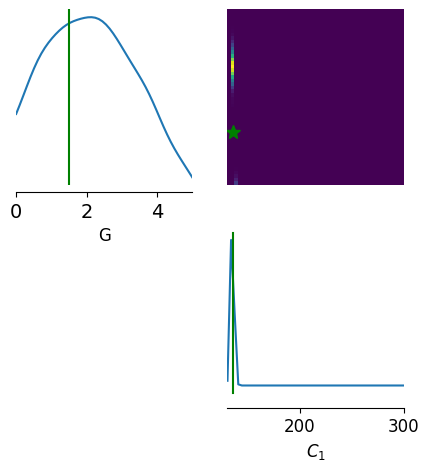

In [106]:
limits = [[lo, hi] for lo, hi in zip(PRIOR_BOUNDS_MIN, PRIOR_BOUNDS_MAX)]
point = TRUE_THETA.reshape(1, -1)
fig, ax = pairplot_numpy(
    posterior_samples,
    limits=limits,
    figsize=(5, 5),
    points=point,
    labels=["G", r"$C_{1}$"],
    upper="kde",
    diag="kde",
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["g"],
    ),
)
ax[0, 0].tick_params(labelsize=14)
ax[0, 0].margins(y=0)
fig.savefig(os.path.join(OUT_DIR, "jr_sde_cde_pairplot.jpeg"), dpi=300)
print("Saved figure →", os.path.join(OUT_DIR, "jr_sde_cde_pairplot.jpeg"))